In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.stats import gaussian_kde

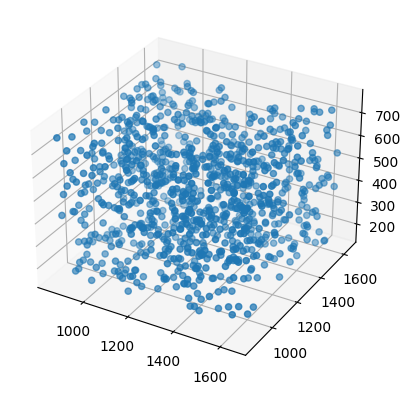

In [2]:
dx = 15  # the approximate size of the cell in μm
sz = np.ceil([2500 / dx, 2500 / dx, 917 / dx]).astype(int)  # scale to the cell size

# Let's create some cells
center = np.array([2500 / 2, 2500 / 2, 917 / 2])
coords1 = np.random.randint(-400, 400, (1000,)) + center[0]
coords2 = np.random.randint(-400, 400, (1000,)) + center[1]
coords3 = np.random.randint(-300, 300, (1000,)) + round(center[2])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords1, coords2, coords3)
np.savetxt('test_coordinates_D0.txt', np.column_stack((coords1, coords2, coords3)))

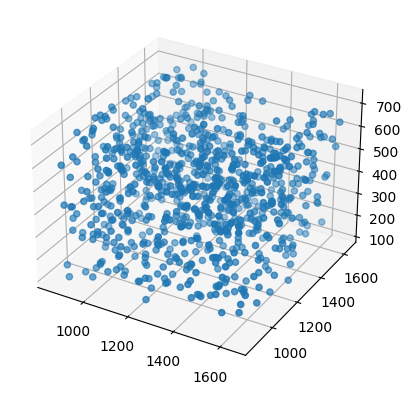

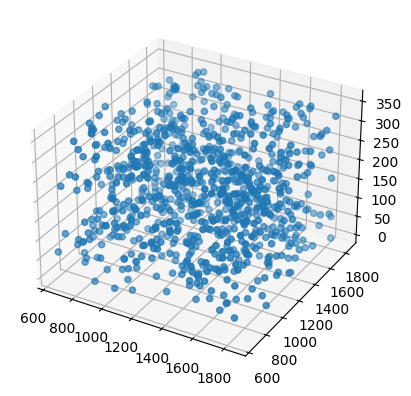

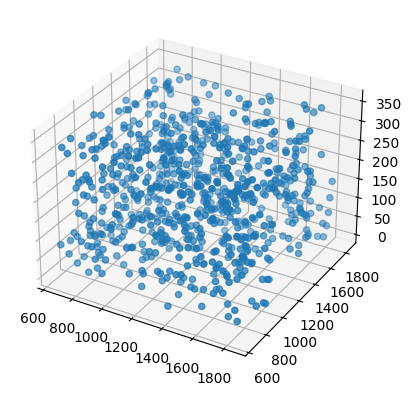

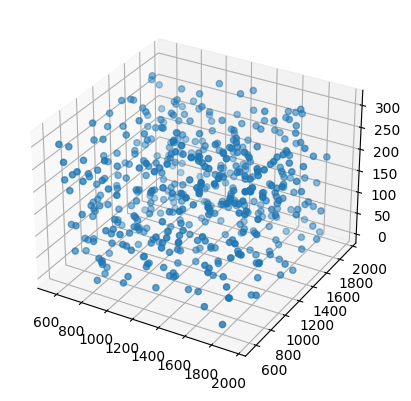

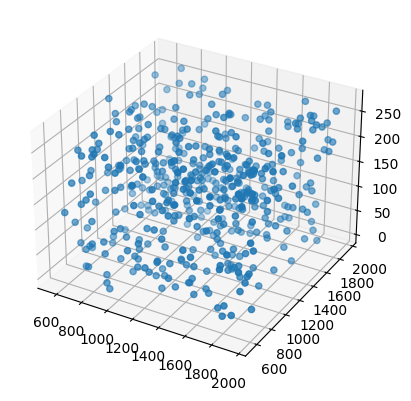

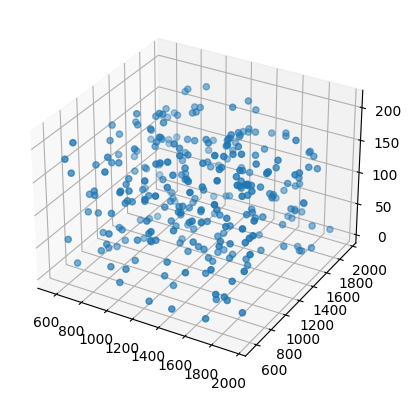

In [3]:
coords1 = np.random.randint(-400, 400, (900,)) + center[0]
coords2 = np.random.randint(-400, 400, (900,)) + center[1]
coords3 = np.random.randint(-300, 300, (900,)) + round(center[2] / 1.1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords1, coords2, coords3)
np.savetxt('test_coordinates_D2.txt', np.column_stack((coords1, coords2, coords3)))

coords1 = np.random.randint(-600, 600, (900,)) + center[0]
coords2 = np.random.randint(-600, 600, (900,)) + center[1]
coords3 = np.random.randint(-150, 200, (900,)) + round(center[2] / 3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords1, coords2, coords3)
np.savetxt('test_coordinates_D5.txt', np.column_stack((coords1, coords2, coords3)))

coords1 = np.random.randint(-600, 600, (800,)) + center[0]
coords2 = np.random.randint(-600, 600, (800,)) + center[1]
coords3 = np.random.randint(-150, 200, (800,)) + round(center[2] / 3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords1, coords2, coords3)
np.savetxt('test_coordinates_D7.txt', np.column_stack((coords1, coords2, coords3)))

coords1 = np.random.randint(-700, 700, (500,)) + center[0]
coords2 = np.random.randint(-700, 700, (500,)) + center[1]
coords3 = np.random.randint(-114, 200, (500,)) + round(center[2] / 4)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords1, coords2, coords3)
np.savetxt('test_coordinates_D9.txt', np.column_stack((coords1, coords2, coords3)))


coords1 = np.random.randint(-700, 700, (500,)) + center[0]
coords2 = np.random.randint(-700, 700, (500,)) + center[1]
coords3 = np.random.randint(-90, 180, (500,)) + round(center[2] / 5)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords1, coords2, coords3)
np.savetxt('test_coordinates_D12.txt', np.column_stack((coords1, coords2, coords3)))

coords1 = np.random.randint(-700, 700, (300,)) + center[0]
coords2 = np.random.randint(-700, 700, (300,)) + center[1]
coords3 = np.random.randint(-90, 120, (300,)) + round(center[2] / 5)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords1, coords2, coords3)
np.savetxt('test_coordinates_D14.txt', np.column_stack((coords1, coords2, coords3)))

Initializing density estimation with dxyz=15μm
Importing coordinates from D0
Importing coordinates from D2
Importing coordinates from D5
Importing coordinates from D7
Importing coordinates from D9
Importing coordinates from D12
Importing coordinates from D14


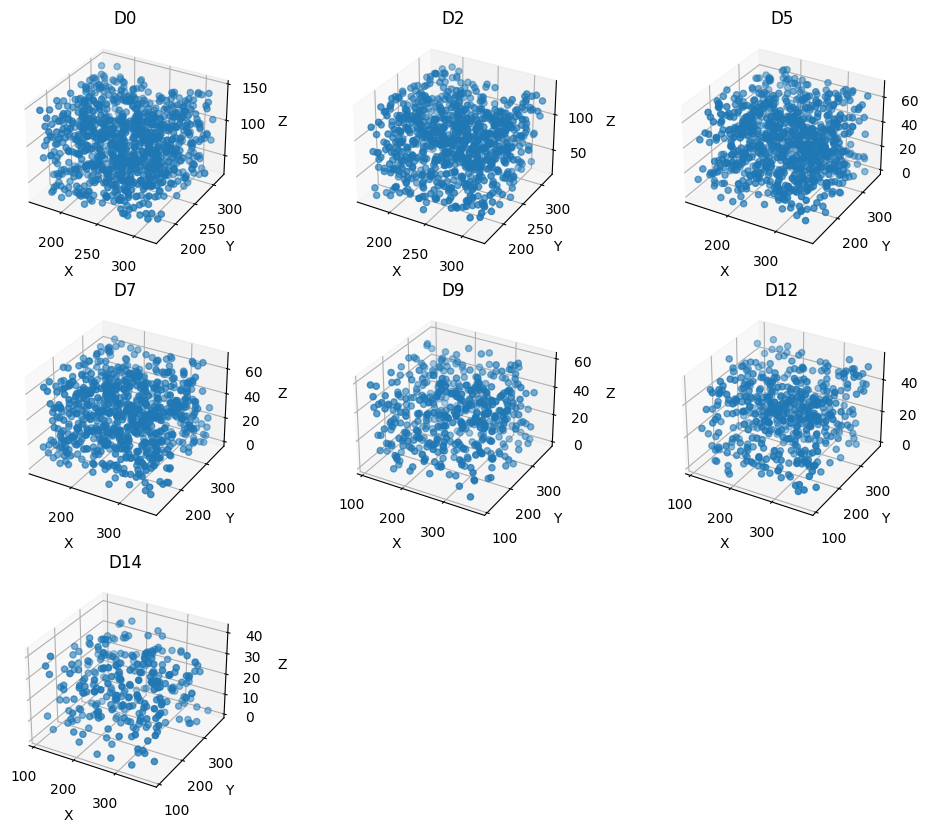

In [20]:
# For the interpolation
x = np.linspace(0, 2.5, sz[0])
z = np.linspace(0, 0.917, sz[2])
X, Y, Z = np.meshgrid(x, x, z)
szq = np.array([480, 480, 176])  # the number of grid points in the simulation domain
xq = np.linspace(0, 2.5, szq[0])
zq = np.linspace(0, 0.917, szq[2])
Xq, Yq, Zq = np.meshgrid(xq, xq, zq)
dsxy = 2500 / 480  # downscale parameter for xy-plane
dsz = 917 / 176  # downscale parameter for z-dimension

print('Initializing density estimation with dxyz=' + str(dx) + 'μm')

# Import coordinates
fnames = 'test_coordinates_'
day_names = ['D0', 'D2', 'D5', 'D7', 'D9', 'D12', 'D14']
ndays = len(day_names)
coord = {}

fig = plt.figure(figsize=(12,10))
for i in range(ndays):
    print('Importing coordinates from ' + day_names[i])
    coord[day_names[i]] = np.loadtxt(fnames + day_names[i] + '.txt')
    coord[day_names[i]][:, 0:2] = np.ceil(coord[day_names[i]][:, 0:2] / dsxy)  # scale such that cells become points
    coord[day_names[i]][:, 2] = np.ceil(coord[day_names[i]][:, 2] / dsz)
    coord[day_names[i]][:, 0:2] += 1

    
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    ax.scatter(coord[day_names[i]][:, 0], coord[day_names[i]][:, 1], coord[day_names[i]][:, 2])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(day_names[i])

plt.show()

In [25]:
# Convert centroids to density (patience...)
print('Converting points to density...')
X1, X2, X3 = np.meshgrid(np.arange(1, szq[0] + 1), np.arange(1, szq[1] + 1), np.arange(1, szq[2] + 1))
d = 3
grid = np.reshape([X1.ravel(), X2.ravel(), X3.ravel()], (szq[0] * szq[1] * szq[2], d))
PV = {}

for i in range(ndays):
    kde = gaussian_kde(coord[day_names[i]].T)
    dmt = kde(grid.T)
    PV[day_names[i]] = dmt * len(coord[day_names[i]]) * (15 ** 3) / (5.21 ** 3)
    print('min PV =', np.min(PV[day_names[i]]))
    print('max PV =', np.max(PV[day_names[i]]))
    PV[day_names[i]] = PV[day_names[i]].reshape([480, 480, 176])



Converting points to density...
min PV = 2.422882226534598e-207
max PV = 0.0003596254570994372
min PV = 5.829469180777314e-216
max PV = 0.00024670411791239674
min PV = 0.0
max PV = 0.002379515225019666
min PV = 0.0
max PV = 0.0025953776874284326
min PV = 0.0
max PV = 0.0014065540724836896
min PV = 0.0
max PV = 0.0015185940963863545
min PV = 0.0
max PV = 0.0009541003384806804


Plotting density...
 -> D0


AttributeError: 'Axes3D' object has no attribute 'isosurface'

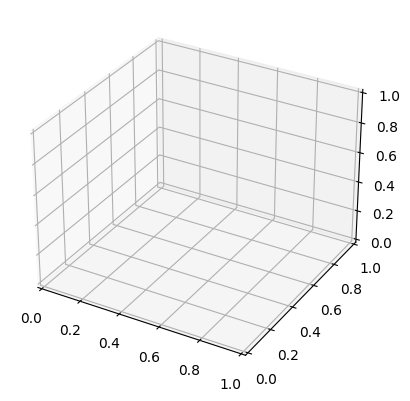

In [26]:
print('Plotting density...')
cmap = plt.cm.winter(np.linspace(0, 1, 50))[::-1]
depth = 0.2

for i in range(ndays):
    print(' -> ' + day_names[i])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    isovalue3 = depth * (np.max(PV[day_names[i]]) - np.min(PV[day_names[i]])) + np.min(PV[day_names[i]])
    surf3 = ax.isosurface(Xq, Yq, Zq, PV[day_names[i]], isovalue3, cmap=cmap[-4])
    ax.add_collection3d(Poly3DCollection(surf3.vertices, facecolors=cmap[-4], edgecolors='none', alpha=0.4))
    ax.set_xlim([0, 2.5])
    ax.set_ylim([0, 2.5])
    ax.set_zlim([0, 0.917])

In [ ]:
# Save matrices to binary files
print('Saving...')
os.makedirs('IC', exist_ok=True)
for i in range(ndays):
    with open(f'IC/new_dens_{day_names[i]}.raw', 'wb') as file:
        file.write(PV[day_names[i]].tobytes())

print('Finished!')